In [1]:
import numpy as np
from itertools import product
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

**generate_pins**     
* Generates the position of pins, given a particular number of pins, wheel pixel size, and nail pixel size.
* Creates 2 lists of positions (one for the anticlockwise side, one for the clockwise), and meshes them together so that the order they appear in the final output is the order of nodes anticlockwise around the frame.

**through_pixels**
* Finds which pixels a line between particular pins runs through.
* Adjusted so that the number of pixels (approximately) equals the distance between the pins.

**build_through_pixels_dict**
* Uses through_pixels to build up a dictionary of all possible lines connecting 2 pins.
* Can be run at the start of a project, and doesn't need to be run again.
* Uses a cubic regression to estimate how long is left while it runs.

In [2]:
def generate_pins(npins, wheel_pixel_size, nail_pixel_size):
    
    r = (wheel_pixel_size / 2) - 1
    
    theta = (np.arange(npins, dtype="float64") / npins) * (2 * np.pi)
    
    epsilon = np.arcsin(nail_pixel_size / wheel_pixel_size)
    
    theta_acw = theta.copy() + epsilon
    theta_cw = theta.copy() - epsilon

    theta = np.stack((theta_cw, theta_acw)).ravel("F")
    
    x = r * (1 + np.cos(theta)) + 0.5
    y = r * (1 + np.sin(theta)) + 0.5
    
    return np.array((x,y)).T


def through_pixels(p0, p1):
    
    d = max(int(((p0[0]-p1[0])**2 + (p0[1]-p1[1])**2) ** 0.5), 1)
    
    pixels = np.array([p0 + (p1-p0)*(i/d) for i in range(0, d+1)])
    pixels = np.unique(np.round(pixels), axis=0).astype(int)
    
    return pixels


def build_through_pixels_dict(npins, wheel_pixel_size, nail_pixel_size):

    n_pin_sides = npins * 2

    l = [(0,1)]
    for j in range(n_pin_sides):
        for i in range(j):
            if j-i > 10 and j-i < (n_pin_sides - 10):
                l.append((i, j))
    
    random_order = np.random.choice(len(l),len(l),replace=False)
    
    d = {}    
    t_list = []
    t0 = time.time()
    
    for n in range(len(l)):
        (i, j) = l[random_order[n]]
        p0, p1 = pins[i], pins[j]
        d[(i,j)] = through_pixels(p0, p1)
        
        t = time.time() - t0
        t_left = t * (len(l) - n - 1) / (n + 1)
        print(f"time left = {hms_format(t_left)}", end="\r")
    
    clear_output()
    return d


def hms_format(t):
    t = [int(t/3600), int((t%3600)/60), int(t%60)]
    for i in range(3):
        t[i] = "0"*int(2-len(str(t[i]))) + str(t[i])
    return f"{t[0]}:{t[1]}:{t[2]}"

**fitness**
* Measures how much line improves image. improvement is average (per pixel) difference in penalty, i.e. average of new penalty - old penalty (where a smaller penalty is better).
* Penalty is the sum of absolute values of positive pixels, minus absolute values of negative pixels times a lightness penalty. If the lightness penalty is 1, going over light areas is as bad as not going over dark areas, so not enough lines get drawn. If the lightness penalty is 0, the algorithm won't care about going over light areas as long as it goes over dark areas as well, so too many lines will be drawn. It needs to be balanced between these 2 extremes (normally about 0.4-0.6).
* The adding parameter in fitness means that it can calculate the improvement either from adding a line, or from removing a line that is already in the image.

**optimise_fitness**
* Process of adding a new line is as follows:
    1. Generates random lines (ensuring they aren't the same line, or the same but reversed, or connecting the same pin), then finds the line with the best fitness.
    2. Subtracts this line from the image.
    3. Returns the new image, the best line, and a boolean that says whether a line is being added or removed.

In [3]:
def fitness(image, i, j, darkness, lightness_penalty, w, w_pos, w_neg, line_norm_mode, adding):
    
    pixels = through_pixels_dict[(i, j)]
    
    old_pixel_values = np.array([image[p[0],p[1]] for p in pixels])
    
    if adding:
        new_pixel_values = old_pixel_values - darkness
    else:
        new_pixel_values = old_pixel_values + darkness
    
    if type(w) == bool and type(w_pos) == bool:
        new_penalty = sum(new_pixel_values[new_pixel_values > 0]) \
                      - lightness_penalty * sum(new_pixel_values[new_pixel_values < 0])           
        old_penalty = sum(old_pixel_values[old_pixel_values > 0]) \
                      - lightness_penalty * sum(old_pixel_values[old_pixel_values < 0])
    elif type(w_pos) == bool:
        pixel_weightings = np.array([w[p[0],p[1]] for p in pixels])
        new_penalty = sum((new_pixel_values*pixel_weightings)[new_pixel_values > 0]) \
                      - lightness_penalty * sum((new_pixel_values*pixel_weightings)[new_pixel_values < 0])           
        old_penalty = sum((old_pixel_values*pixel_weightings)[old_pixel_values > 0]) \
                      - lightness_penalty * sum((old_pixel_values*pixel_weightings)[old_pixel_values < 0])
    elif type(w) == bool:
        pos_pixel_weightings = np.array([w_pos[p[0],p[1]] for p in pixels])
        neg_pixel_weightings = np.array([w_neg[p[0],p[1]] for p in pixels])  
        new_penalty = sum((new_pixel_values*pos_pixel_weightings)[new_pixel_values > 0]) \
                      - lightness_penalty * sum((new_pixel_values*neg_pixel_weightings)[new_pixel_values < 0])           
        old_penalty = sum((old_pixel_values*pos_pixel_weightings)[old_pixel_values > 0]) \
                      - lightness_penalty * sum((old_pixel_values*neg_pixel_weightings)[old_pixel_values < 0])
    
    if line_norm_mode == "length":
        line_norm = len(pixels)
    elif line_norm_mode == "weighted length":
        if type(w_pos) == bool:
            line_norm = sum(pixel_weightings)
        else:
            line_norm = sum(pos_pixel_weightings)
    elif line_norm_mode == "none":
        line_norm = 1
        
    if line_norm == 0:
        return 0
    else:
        return (new_penalty - old_penalty) / line_norm


def optimise_fitness(image, nrandom, darkness, lightness_penalty, npins, list_of_lines, w, w_pos, w_neg, line_norm_mode):
    
    n_pin_sides = npins * 2
    
    rand_numbers = np.random.choice(n_pin_sides**2, nrandom, replace=False)
        
    rand_lines = [sorted((int(i/n_pin_sides), i%n_pin_sides)) for i in rand_numbers]
        
    best_fitness = 0
    best_line = (0,1)
    
    for line in rand_lines:
        
        (i, j) = line
                
        if j-i > 10 and j-i < (n_pin_sides - 10):
            
            new_fitness = fitness(image, i, j, darkness, lightness_penalty, w, w_pos, w_neg, line_norm_mode, 
                                  adding = line not in list_of_lines)
            
            if new_fitness <= best_fitness:
                
                best_fitness = new_fitness
                best_line = line
    
    p0, p1 = pins[best_line[0]], pins[best_line[1]]
    
    adding = best_line not in list_of_lines    
    
    if adding:
        for p in through_pixels_dict[tuple(best_line)]:
            image[p[0],p[1]] -= darkness
    else:
        for p in through_pixels_dict[tuple(best_line)]:
            image[p[0],p[1]] += darkness      
        
    return (image, best_line, adding)  

**find_lines**
* Calls optimise_fitness multiple times to draw a set of lines.
* Updates the image and the list of lines with each line drawn.
* Every 10 lines drawn, prints output that describes the progress of the algorithm.
* Prints total run time of algorithm at the end.

**get_penalty**
* Calculates the total penalty of the image.
* Like other functions, it can do this for an image weighting, or a simplified version if no image weighting is used

In [4]:
def find_lines(image, nlines, nrandom, darkness, lightness_penalty, line_norm_mode, w=False, w_pos=False, w_neg=False):
    
    t0 = time.time()
    list_of_lines = []
    
    for i in range(nlines):
        
        if i == 0:
            initial_penalty = get_penalty(image, lightness_penalty, w, w_pos, w_neg)
            initial_avg_penalty = twodp_format(initial_penalty / (wheel_pixel_size ** 2))
            print(f"0/0, average penalty = {initial_avg_penalty}", end="\r")
        elif i%20 == 0:
            t_so_far = hms_format(time.time() - t0)
            t_left = hms_format((time.time() - t0) * (nlines - i) / i)
            penalty = get_penalty(image, lightness_penalty, w, w_pos, w_neg)
            avg_penalty = twodp_format(penalty / (wheel_pixel_size ** 2))
            print(f"{len(list_of_lines)}/{i}, average penalty = {avg_penalty}/{initial_avg_penalty}, \
time = {t_so_far}, time left = {t_left}", end="\r")                
        
        image, line, adding = optimise_fitness(image, nrandom, darkness, lightness_penalty, npins, list_of_lines, 
                                               w, w_pos, w_neg, line_norm_mode)
        if adding:
            list_of_lines.append(line)
        else:
            list_of_lines.remove(line)
  
    clear_output()
    
    penalty = get_penalty(image, lightness_penalty, w, w_pos, w_neg)
    avg_penalty = twodp_format(penalty / (wheel_pixel_size ** 2))
    print(f"{len(list_of_lines)}/{nlines}, average penalty = {avg_penalty}/{initial_avg_penalty}")
    print("time = " + hms_format(time.time() - t0))
    
    return list_of_lines


def twodp_format(n):
    n = np.round(n, 2)
    if (n*100) % 10 == 0:
        return str(n) + "0"
    else:
        return str(n)
        

def get_penalty(image, lightness_penalty, w, w_pos, w_neg):
    
    if type(w) == bool and type(w_pos) == bool:
        return sum(image[image>0]) - lightness_penalty*sum(image[image<0])
    elif type(w_pos) == bool:
        return sum((image*w)[image>0]) - lightness_penalty*sum((image*w)[image<0])
    elif type(w) == bool:
        return sum((image*w_pos)[image>0]) - lightness_penalty*sum((image*w_neg)[image<0]) 

**prepare_image**
* Takes a jpeg or png image file, and converts it into an array of bytes.
* The input needs to be square, otherwise it will be squashed.
* Colour input (boolean) determines whether image is monochrome (so pixel values = darkness of image) or coloured (so pixel values = saturation of image; note in this case the image must be pre-processed so only the appropriate colour is left).
* Weighting input (boolean) determines whether image is meant to be an importance weighting (so the byte array returned has values between 0 and 1, where 1 means black, so high importance, and 0 means white, so low importance).

**display_images**
* Displays images read from prepare_image in a nice format.

In [5]:
def prepare_image(file_name, colour=False, weighting=False):
    
    image = Image.open(file_name).resize((wheel_pixel_size,wheel_pixel_size))
    
    if colour:
        image = np.array(image.convert(mode="HSV").getdata()).reshape((wheel_pixel_size,wheel_pixel_size,3))[:,:,1]
    elif weighting:     
        image = 1 - np.array(image.convert(mode="L").getdata()).reshape((wheel_pixel_size,wheel_pixel_size)) / 255
    else:
        image = 255 - np.array(image.convert(mode="L").getdata()).reshape((wheel_pixel_size,wheel_pixel_size))

    for (i,j) in product(range(wheel_pixel_size), range(wheel_pixel_size)):
        if ((i - (wheel_pixel_size-1)*0.5)**2 + (j - (wheel_pixel_size-1)*0.5)**2)**0.5 > wheel_pixel_size*0.5:
            image[i,j] = 0                                
            
    return image.T[:,::-1]

def display_images(image_list):
    
    fig, axs = plt.subplots(1,len(image_list),figsize=(30,30));
    for (i,j) in zip(range(len(image_list)), image_list):
        axs[i].set_yticklabels([])
        axs[i].set_xticklabels([])
        axs[i].imshow(j[:,::-1].T, cmap=plt.get_cmap("Greys"));

**save_plot**
* Saves the plot of lines under a specified title - can then be opened with GIMP.
* Colours are added in the order they appear in the list.
* Uses RGB format.

**save_plot_progress**
* Saves the plot midway through construction, at specified points.

In [6]:
def save_plot(list_coloured_lines, list_colours, file_name, size):
        
    new_pins = generate_pins(npins, size, nail_pixel_size)
    
    for i in range(len(new_pins)):
        new_pins[i] = [new_pins[i][0], size - new_pins[i][1]]
    
    thread_image = Image.new('RGB', (size,size), (255,255,255))
    draw = ImageDraw.Draw(thread_image)
    
    for (lines, colour) in zip(list_coloured_lines, list_colours):
        pixel_pairs = [(new_pins[n[0]], new_pins[n[1]]) for n in lines]
        for j in pixel_pairs:
            draw.line((tuple(j[0]), tuple(j[1])), fill=colour)
        
    thread_image.save(file_name + ".jpg", format="JPEG")
    
def save_plot_progress(list_coloured_lines, list_colours, file_name, proportion_list, size):
    
    for prop in proportion_list:
        file_name_temp = f"{file_name} {int(100*prop)}"
        lines_temp = list_coloured_lines[-1][:int(len(list_coloured_lines[-1])*prop)]
        list_coloured_lines_temp = list_coloured_lines[:-1] + [lines_temp]
        save_plot(list_coloured_lines_temp, list_colours, file_name_temp, size=size)

* 
* 
* 

In [13]:
wheel_real_size = 0.58
nail_real_size = 6 * (10**-3)
wheel_pixel_size = 3200
nail_pixel_size = (nail_real_size / wheel_real_size) * wheel_pixel_size
npins = 160

pins = generate_pins(npins, wheel_pixel_size, nail_pixel_size)
through_pixels_dict = build_through_pixels_dict(npins, wheel_pixel_size, nail_pixel_size)

In [29]:
#image_black = prepare_image("ah_12.jpg")
#image_wneg = prepare_image("ah_wneg_6.jpg", weighting=True)
#image_wpos = prepare_image("ah_wpos_6.jpg", weighting=True)
image_white = prepare_image("ah_white_03.jpg")

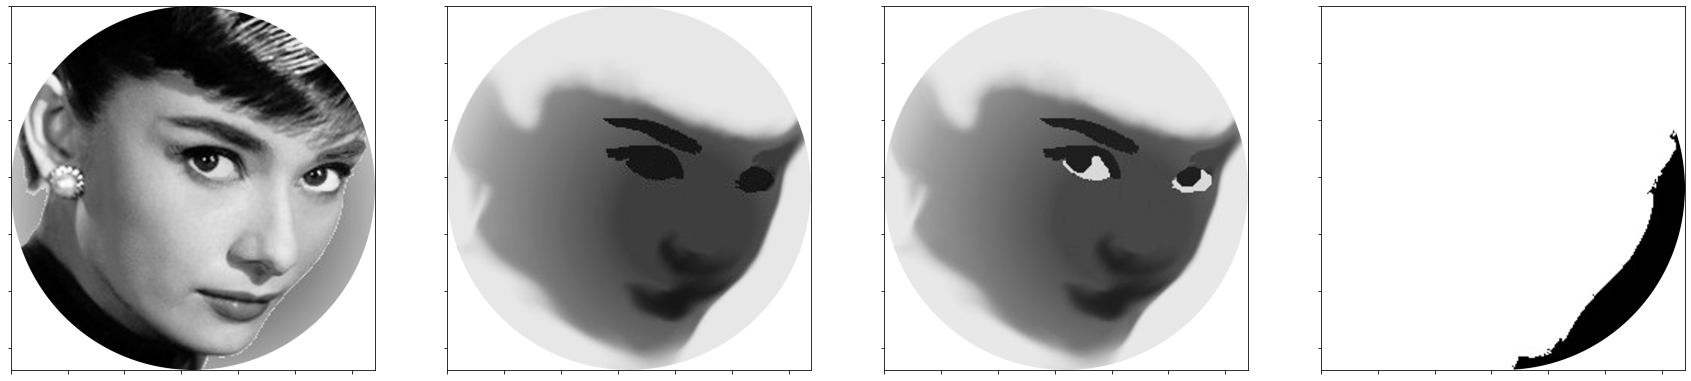

In [30]:
image_list = [image_black, image_wneg, image_wpos, image_white]
display_images(image_list)

In [31]:
lines_white = find_lines(image_white, nlines=200, nrandom=70, darkness=250, lightness_penalty=1.2, 
                         line_norm_mode="length")

198/200, average penalty = 12.66/16.17
time = 00:00:32


In [32]:
save_plot([lines_white], [(0,0,0)], "ahw", 3200)

* 
* 
* 

In [33]:
class edge():
    
    def __init__(self, A, B):
        self.A = A
        self.B = B
        self.A_vertex = int(A/2)
        self.B_vertex = int(B/2)
        self.A_direction = A%2
        self.B_direction = B%2
        
    def __repr__(self):
        return ("({}, {})".format(self.A, self.B))
    
    def __eq__(self, other):
        return str(self) == str(other)
    
    def backwards(self):
        return edge(self.B, self.A)
    
    def connected(self, e):
        return self.B_vertex == e.A_vertex and self.B_direction != e.A_direction
        
    def next_edges(self, edge_list):
        
        forwards_edge_list = [e for e in edge_list if self.connected(e)]
        backwards_edge_list = [e.backwards() for e in edge_list if self.connected(e.backwards())]
        
        edge_list = forwards_edge_list + backwards_edge_list
        
        return edge_list

**extra_edges_parity_correct**
* Takes in edge_list and returns the extra edges needed so that every pin has the same number of edges on either side.
* In the final section, it 0-1 pairs going clockwise (so the manual threading is easiest). This is quite complicated, so there is annotation on the algorithm.

**get_closest_pair**
* Used in the extra_edges_parity_correct algorithm, to find the closest 0-1 pair to match up.

In [34]:
def extra_edges_parity_correct(edge_list, n_vertices):
        
    d = {n : 0 for n in range(n_vertices)}
    
    for e in edge_list:
        
        if e.A_direction == 0:
            d[e.A_vertex] -= 1
        elif e.A_direction == 1:
            d[e.A_vertex] += 1
    
        if e.B_direction == 0:
            d[e.B_vertex] -= 1
        elif e.B_direction == 1:
            d[e.B_vertex] += 1
    
    extra_edges = []
    
    """first while loop adds edges until the number that need 0-connections is same as the number that need 1s"""
    while True:
        s0 = sum([max(i,0) for i in d.values()])
        s1 = sum([-min(i,0) for i in d.values()])
        if s0 == s1:
            break
        elif s0 > s1:
            need_a_zero = [i for i in d.keys() if d[i] > 0]
            a, b, distance = get_closest_pair(need_a_zero, need_a_zero, n_vertices)
            d[a] -= 1
            d[b] -=1
            A = 2*a
            B = 2*b
            extra_edges.append(edge(A,B))
        elif s1 > s0:           
            need_a_one = [i for i in d.keys() if d[i] < 0]
            a, b, distance = get_closest_pair(need_a_one, need_a_one, n_vertices)
            d[a] += 1
            d[b] +=1
            A = 2*a+1
            B = 2*b+1
            extra_edges.append(edge(A,B))  
        print("1st stage: pairing {}, {}, with distance = {}".format(A,B,distance))
        
    """second while loop connects the closest pair that need an extra 0-connection and 1-connection respectively (close in the
    sense that the pin needing a 0 should be a short distance anticlockwise from the pin needing a 1)."""
    while sum([abs(i) for i in d.values()]) > 0:      
        need_a_zero = [n for n in d.keys() if d[n] > 0]
        need_a_one = [n for n in d.keys() if d[n] < 0]
        a, b, distance = get_closest_pair(need_a_zero, need_a_one, n_vertices) #see cell below
        d[a] -= 1
        d[b] += 1
        A = 2*a
        B = 2*b + 1
        extra_edges.append(edge(A,B))
        print("2nd stage: pairing {}, {}, with distance = {}".format(A,B,distance))

    return extra_edges


def get_closest_pair(need_a_zero, need_a_one, n_vertices):
    
    best_distance = n_vertices
    
    for a in need_a_zero:
        for b in need_a_one:
            new_distance = (a-b)%n_vertices
            if new_distance < best_distance and new_distance != 0:
                best_distance = new_distance
                best_a = a
                best_b = b

    return (best_a, best_b, best_distance)

**extra_edges_connect_graph**
* Adds extra edges so that the graph is connected.
* Takes the 2 closest pins in disconnected islands, and joins them using a double bridge.
* This is an inefficient way to add edges, but since most graphs will already be connected (or very nearly), I think there's no point improving this.

**add_connected_vertex**
* Takes a set of vertices and an edge list, and adds a vertex not currently in s that can be connected (by an edge in the edge_list) to the rest of s.
* The boolean at the end says whether a new vertex was successfully added, if not then it is necessary to add a new edge.

**get_adjacant_vertices**
* Takes a set of vertices and its compliment, and returns a pair of vertices (in set and compliment respectively) that are a distance of 1 apart from each other.

In [35]:
def extra_edges_connect_graph(edge_list):
    
    full_vertex_set = set()
    for i in edge_list:
        full_vertex_set.add(i.A_vertex)
        full_vertex_set.add(i.B_vertex)
        
    connected_vertex_set = set([edge_list[0].A_vertex, edge_list[0].B_vertex])
    
    extra_edges = []
    
    while len(connected_vertex_set) < len(full_vertex_set):
        
        connected_vertex_set, found_new_vertex = add_connected_vertex(connected_vertex_set, edge_list)
                
        if not found_new_vertex:
            
            v0, v1 = get_adjacant_vertices(connected_vertex_set, full_vertex_set - connected_vertex_set)
            
            extra_edges += [edge(2*v0, 2*v1), edge(2*v0+1, 2*v1+1)]
            
            connected_vertex_set.add(v0)
            connected_vertex_set.add(v1)
            
    return extra_edges


def add_connected_vertex(conected_vertex_set, edge_list):

    for i in edge_list:
        
        if (i.A_vertex in conected_vertex_set) ^ (i.B_vertex in conected_vertex_set):
                
            conected_vertex_set.add(i.A_vertex)
            conected_vertex_set.add(i.B_vertex)
            return (conected_vertex_set, True)
    
    return (conected_vertex_set, False)


def get_adjacant_vertices(s, t):

    for i in s:
        for j in t:
            if abs(i-j) == 1:
                return (i, j) 

**create_cycle**
* Creates a path from edges in edge_list, starting from first_edge. 
* Returns path, and new reduced edge_list.
* Note that the path returned will only (definitely) be a cycle if the edge_list is parity-corrected.

**add_cycle**
* Takes a cycle and edge_list, and goes through the cycle trying to find a place to insert a new cycle, using edges from edge_list.
* Once it finds a place, it inserts a cycle, and returns the new extended cycle, and the new reduced edge_list.

**create_full_cycle**
* Takes a (connected + parity-corrected) edge_list, and keeps adding cycles to it using add_cycle, until all edges have been added.

In [36]:
def create_cycle(edge_list, first_edge):
    
    cycle = [first_edge]
    
    while True:
        
        try:
            next_edge = cycle[-1].next_edges(edge_list)[0]
            
            cycle.append(next_edge)
                        
            if next_edge in edge_list:
                edge_list.remove(next_edge)
            else:
                next_edge = next_edge.backwards()
                edge_list.remove(next_edge)
                
        except:
            
            return cycle, edge_list
        
        
def add_cycle(cycle, edge_list):
    
    for i in range(len(cycle)):
        
        cycle = [cycle[-1]] + cycle[:-1]
        
        try:
            edge_list_copy = edge_list
            new_cycle, edge_list_copy = create_cycle(edge_list_copy, cycle[-1])
            if len(new_cycle) > 1:
                return cycle + new_cycle[1:], edge_list_copy
        except:
            print("go to add_cycle function, error 1")
    
    print("go to add_cycle function, error 2")
    
    
def create_full_cycle(edge_list):
    
    cycle, edge_list = create_cycle(edge_list[1:], edge_list[0])
    
    while len(edge_list) > 0:
        
        cycle, edge_list = add_cycle(cycle, edge_list)
    
    return cycle

**edges_to_output**
* Takes in non-parity-corrected edges, and uses all the functions above to return a formatted output.
* Also uses cut_down function (see below).

**cut_down**
* Removes sequences of multiple "outside" strings, replacing them with one direct string.

In [37]:
def edges_to_output(line_list, n_vertices):
    
    edge_list = [edge(i[0],i[1]) for i in line_list if type(i) == list]
        
    correction_edges = extra_edges_parity_correct(edge_list, n_vertices)
            
    correction_edges += extra_edges_connect_graph(edge_list + correction_edges)
    
    full_cycle = create_full_cycle(edge_list + correction_edges)
    
    l = [0] * len(full_cycle)
    
    for i in correction_edges:
        for j in range(len(full_cycle)):
            if (i == full_cycle[j] or i.backwards() == full_cycle[j]) and l[j] == 0:
                l[j] = 1
                break
                        
    full_cycle, l = cut_down(full_cycle, l)
        
    l = [0] + l[:-1]

    output = []
    
    first_pin = True
        
    for i in zip(full_cycle, l):
        
        n1 = i[0].A_vertex   
        
        if first_pin:
            n2 = i[0].A_direction
            first_pin = False
        else:
            n2 = (i[0].A_direction + 1) % 2
        
        if i[1] == 1:
            n3 = " outside"
        else:
            n3 = ""
            
        output.append("{}-{}{}".format(n1, n2, n3))
    
    return full_cycle, output


def cut_down(full_cycle, l):
    
    for i in range(len(l)-1):
                
        if l[i] == 1 and l[i+1] == 1:
            new_full_cycle = full_cycle[:i] + [edge(full_cycle[i].A, full_cycle[i+1].B)] + full_cycle[i+2:]
            new_l = l[:i] + [1] + l[i+2:]
            return cut_down(new_full_cycle, new_l)
        
    if l[-1] == 1 and l[-2] == 1:
        return cut_down(full_cycle[:-1], l[:-1])
    
    return full_cycle, l

**test_output**
* Takes the output, and plots it, just to make sure that everything has worked correctly.
* Need to change this function's parameters each time.

**display**
* Prints all the lines, in groups of 100.

**info**
* Prints out the total distance (in meters) of the thread, and the number of lines.

In [38]:
def test_output(output_list, col_list, file_name="reconstructed"):
    
    nail_pixel_size = (nail_real_size / wheel_real_size) * wheel_pixel_size
    
    reconstructed_lines = []
    
    for n in range(len(output_list)):
        
        reconstructed_lines.append([])
    
        for i in range(len(output_list[n]) - 1):
            a = get_A_vertex(output_list[n][i])
            b = get_B_vertex(output_list[n][i+1])

            if "outside" not in output_list[n][i+1]:
                reconstructed_lines[n].append([a,b])

    save_plot(reconstructed_lines, col_list, file_name, wheel_pixel_size)

def get_A_vertex(code):
    i = code.strip(" outside").split("-")
    i = [int(j) for j in i]
    i = 2*i[0] + (i[1]+1)%2
    return i

def get_B_vertex(code):
    i = code.strip(" outside").split("-")
    i = [int(j) for j in i]
    i = 2*i[0] + i[1]
    return i

def display(output):
    
    count = 0

    for i in output:
        print(i)
        count += 1
        if count % 100 == 0:
            print("\n{}\n".format(count))
            
def info(lines):
    
    nail_pixel_size = (nail_real_size / wheel_real_size) * wheel_pixel_size
    
    lines = [[i.A, i.B] for i in lines]
    pins = generate_pins(npins, wheel_pixel_size, nail_pixel_size)
    lines = [(pins[n[0]], pins[n[1]]) for n in lines]

    d = 0
    for i in lines:
        d += ((i[0][0]-i[1][0])**2 + (i[0][1]-i[1][1])**2) ** 0.5
    
    d = d * (wheel_real_size / wheel_pixel_size)
    
    print(f"distance = {int(d)} meters\n# lines = {len(lines)}\n")   

* 
* 
* 

In [39]:
final_instructions = edges_to_output(lines_white, 180)
info(final_instructions[0])

1st stage: pairing 7, 5, with distance = 1
1st stage: pairing 7, 5, with distance = 1
2nd stage: pairing 12, 11, with distance = 1
2nd stage: pairing 12, 11, with distance = 1
2nd stage: pairing 12, 11, with distance = 1
2nd stage: pairing 248, 247, with distance = 1
2nd stage: pairing 266, 265, with distance = 1
2nd stage: pairing 270, 269, with distance = 1
2nd stage: pairing 270, 269, with distance = 1
2nd stage: pairing 270, 269, with distance = 1
2nd stage: pairing 274, 273, with distance = 1
2nd stage: pairing 274, 273, with distance = 1
2nd stage: pairing 274, 273, with distance = 1
2nd stage: pairing 274, 273, with distance = 1
2nd stage: pairing 274, 273, with distance = 1
2nd stage: pairing 292, 291, with distance = 1
2nd stage: pairing 292, 291, with distance = 1
2nd stage: pairing 298, 297, with distance = 1
2nd stage: pairing 314, 313, with distance = 1
2nd stage: pairing 314, 313, with distance = 1
2nd stage: pairing 318, 317, with distance = 1
2nd stage: pairing 318, 317

In [40]:
display(final_instructions[1])
test_output([final_instructions[1]], [(0,0,0)])

1-0
145-0
158-0
129-0
141-1
159-1
158-1 outside
132-1
151-0
126-0
145-1
155-0
148-0
137-1
136-1 outside
141-1
158-0
127-0
156-1
140-0
146-0
140-0
122-0
130-0
147-0
0-1
136-0
144-1
159-1
158-1 outside
128-0
135-0
149-1
148-1 outside
6-1
149-0
157-1
156-1 outside
133-1
150-1
157-1
156-1 outside
130-1
138-1
154-0
129-0
154-0
132-0
156-0
126-0
154-0
138-0
147-1
157-1
154-1 outside
124-1
141-1
147-1 outside
159-1
147-1 outside
139-0
151-0
153-0 outside
1-0
8-0
10-0 outside
0-1
127-1
149-0
125-1
152-0
130-1
135-1
134-1 outside
148-1
128-0
151-0
153-0 outside
143-1
149-1
124-1
123-1 outside
143-1
144-1 outside
3-0
131-1
157-1
150-1 outside
5-0
143-0
4-1
157-1
148-1 outside
125-0
138-1
157-1
148-1 outside
126-0
149-0
133-1

100

146-1
157-0
133-0
157-0
136-0
156-1
131-0
145-0
7-0
152-0
8-0
121-0 outside
132-1
159-0
136-0
122-0
128-0
158-1
130-1
128-1 outside
151-0
153-0 outside
127-1
138-1
134-1 outside
155-0
128-0
2-0
3-1 outside
130-1
128-1 outside
152-0
127-0
143-0
6-1
138-0
133-0
140-1
2-1